# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import scipy

from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Data loading

In [2]:
xls = pd.ExcelFile('data/edited_nikos_data.xlsx')
xls.sheet_names

['ANAMET',
 'Anamet data',
 'ISRI',
 'Isri data',
 'UNS data',
 'Elements data',
 'Material data',
 'Process']

In [3]:
uns_data = pd.read_excel(xls, 'UNS data')

uns_data.rename(columns = {'sc:isComposedOf':'elements id'}, inplace = True)

elements_data = pd.read_excel(xls, 'Elements data')

uns_data = pd.merge(uns_data, elements_data, how='inner', on = 'elements id')
isri_data = pd.read_excel(xls, 'Isri data')
anamet_data = pd.read_excel(xls, 'Anamet data')
material_data = pd.read_excel(xls, 'Material data')
elements_data = pd.read_excel(xls, 'Elements data')

In [4]:
isri_data.head(2)

,isri id,sc:hasCategory,sc:hasForm,sc:isFreeFrom,sc:contains,sc:hasISRICode,sc:hasSpecification,pc:hasName,sc:isComposedOf,sc:isProcessedBy
0,sc:ISRI_0,Nonferrous Scrap - Red Metals,Wire,NaN,Copper,Berry,"Bare, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257
1,sc:ISRI_1,Nonferrous Scrap - Red Metals,Wire and Cable,"Brittle Burnt Wire, Copper Tubing",Copper,Barley,"Clean, Untinned, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257


In [5]:
anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory,sc:internal_code,sc:isProcessedBy
0,sc:ANAMET_437,ΣΚΡΑΠ ΨΑΛΙΔΙΣΜΕΝΟ ΠΥΚΝ >450 ΚG/M3 (ΥΛΗ),Ferrous,40000,sc:Process_690
1,sc:ANAMET_438,άγνωστο,Ferrous,9000,NaN


In [6]:
uns_data.head(2)

,uns id,sc:hasName,elements id,ar,atomicNumber,density,meltingPoint,hasName,symbol
0,sc:UNS_712,C83300,sc:Elements_329,207.2,82,11.29,327.5,LEAD,Pb
1,sc:UNS_733,C84500,sc:Elements_329,207.2,82,11.29,327.5,LEAD,Pb


# Create `df` using `anamet` and `isri`

Classify a given scrap.

Προσπάθεια classifiaction ενός δοθέντος scap σε anamet / isri δεδομένου ενός description

### Raw data preprocessing

#### `ISRI`

In [7]:
isri_data.head(1)

,isri id,sc:hasCategory,sc:hasForm,sc:isFreeFrom,sc:contains,sc:hasISRICode,sc:hasSpecification,pc:hasName,sc:isComposedOf,sc:isProcessedBy
0,sc:ISRI_0,Nonferrous Scrap - Red Metals,Wire,NaN,Copper,Berry,"Bare, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257


In [8]:
isri_data.shape

(244, 10)

In [9]:
isri_data = isri_data[['isri id', 'sc:hasCategory', 'sc:hasForm', 'sc:hasSpecification', 'sc:contains', 'pc:hasName']]

In [10]:
isri_data.isna().sum()

isri id                 0
sc:hasCategory          0
sc:hasForm             43
sc:hasSpecification    12
sc:contains            68
pc:hasName              7
dtype: int64

In [11]:
import texthero as hero
from texthero import preprocessing

custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_stopwords]

for col in isri_data.drop('isri id', axis=1).columns:
    isri_data[col] = hero.clean(isri_data[col])

isri_data.head(2)

,isri id,sc:hasCategory,sc:hasForm,sc:hasSpecification,sc:contains,pc:hasName
0,sc:ISRI_0,nonferrous scrap red metals,wire,bare uncoated unalloyed,copper,copper wire
1,sc:ISRI_1,nonferrous scrap red metals,wire cable,clean untinned uncoated unalloyed,copper,copper wire


In [12]:
isri_data.isna().sum()

isri id                0
sc:hasCategory         0
sc:hasForm             0
sc:hasSpecification    0
sc:contains            0
pc:hasName             0
dtype: int64

#### `ANAMET`

In [13]:
anamet_data.head()

,anamet entity,sc:description,sc:hasCategory,sc:internal_code,sc:isProcessedBy
0,sc:ANAMET_437,ΣΚΡΑΠ ΨΑΛΙΔΙΣΜΕΝΟ ΠΥΚΝ >450 ΚG/M3 (ΥΛΗ),Ferrous,40000,sc:Process_690
1,sc:ANAMET_438,άγνωστο,Ferrous,9000,NaN
2,sc:ANAMET_439,κουτάκι,Ferrous,9101,NaN
3,sc:ANAMET_440,λαμαρίνες,Ferrous,9102,NaN
4,sc:ANAMET_441,ζάντες + βαρύ προς shredder κλπ από ΟΤΚΖ,Ferrous,9103,NaN


In [14]:
anamet_data.shape

(322, 5)

Keep only ANAMET with english `sc:description`

In [15]:
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) # isalpha suggested by John Machin

e_description_index = []
for row in range(len(anamet_data)):
    if only_roman_chars(str(anamet_data['sc:description'].iloc[row])):
        e_description_index.append(row)
        
anamet_data = anamet_data.iloc[e_description_index]
anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory,sc:internal_code,sc:isProcessedBy
28,sc:ANAMET_465,COPPER SCRAP MILLBERRY CABLES FOR STRIP.,Non-Ferrous,40014,NaN
30,sc:ANAMET_466,COPPER SCRAP BIRCH CABLES FOR STRIPPING,Non-Ferrous,40015,NaN


In [16]:
anamet_data.shape

(214, 5)

In [17]:
anamet_data = anamet_data[['anamet entity', 'sc:description', 'sc:hasCategory']]
anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory
28,sc:ANAMET_465,COPPER SCRAP MILLBERRY CABLES FOR STRIP.,Non-Ferrous
30,sc:ANAMET_466,COPPER SCRAP BIRCH CABLES FOR STRIPPING,Non-Ferrous


In [18]:
anamet_data.isna().sum()

anamet entity     0
sc:description    0
sc:hasCategory    0
dtype: int64

In [19]:
for col in anamet_data.drop('anamet entity', axis=1).columns:
    anamet_data[col] = hero.clean(anamet_data[col])

anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory
28,sc:ANAMET_465,copper scrap millberry cables strip,non ferrous
30,sc:ANAMET_466,copper scrap birch cables stripping,non ferrous


# Combine both datasets

Will combine `ISRI` and `ANAMET` dataframes into one.

In [20]:
df = pd.DataFrame()

In [21]:
isri_data.head(1)

,isri id,sc:hasCategory,sc:hasForm,sc:hasSpecification,sc:contains,pc:hasName
0,sc:ISRI_0,nonferrous scrap red metals,wire,bare uncoated unalloyed,copper,copper wire


In [22]:
anamet_data.head(1)

,anamet entity,sc:description,sc:hasCategory
28,sc:ANAMET_465,copper scrap millberry cables strip,non ferrous


In [23]:
isri_data['corpus'] = isri_data['sc:hasSpecification'] + ' ' + isri_data['sc:hasForm'] + ' '  + isri_data['sc:contains'] + ' ' + isri_data['sc:hasCategory'] + ' '+ isri_data['pc:hasName']
isri_data = isri_data[['isri id', 'corpus']]
isri_data.head(1)

,isri id,corpus
0,sc:ISRI_0,bare uncoated unalloyed wire copper nonferrous...


In [24]:
anamet_data['corpus'] = anamet_data['sc:description'] + ' ' + anamet_data['sc:hasCategory']
anamet_data = anamet_data[['anamet entity', 'corpus']]
anamet_data.head(1)

,anamet entity,corpus
28,sc:ANAMET_465,copper scrap millberry cables strip non ferrous


In [25]:
isri_data.rename(columns = {'isri id':'scrap_type'}, inplace = True)
anamet_data.rename(columns= {'anamet entity':'scrap_type'}, inplace = True)

Concat the dfs

In [26]:
df = pd.concat([isri_data, anamet_data], axis=0)
df

,scrap_type,corpus
0,sc:ISRI_0,bare uncoated unalloyed wire copper nonferrous...
1,sc:ISRI_1,clean untinned uncoated unalloyed wire cable c...
2,sc:ISRI_2,unalloyed miscellaneous wire copper nonferrous...
3,sc:ISRI_3,clean unalloyed uncoated clippings punchings b...
4,sc:ISRI_4,unalloyed miscellaneous scrap copper nonferrou...
...,...,...
317,sc:ANAMET_684,lead scrap e non ferrous
318,sc:ANAMET_685,electric motors shredded weee non ferrous
319,sc:ANAMET_686,black plastic scrap weee e non ferrous
320,sc:ANAMET_687,scrap plexiglass e non ferrous


In [27]:
print( isri_data['scrap_type'].nunique() )
print( anamet_data['scrap_type'].nunique() )
print( df['scrap_type'].nunique() )

244
214
458


Every row is a different scrap type.

### Create a _validation set_

Keep some (~5) examples as validation set

In [28]:
index_test = [10, 100, 120, 200, 289, 320]

df_val = df.iloc[index_test]

df.drop(index=index_test, inplace=True)

df_val

,scrap_type,corpus
10,sc:ISRI_10,various types insulation sold sample recovery ...
100,sc:ISRI_100,clean old used foreign attachments extraneous ...
120,sc:ISRI_120,lead covered copper cable cable lead copper no...
200,sc:ISRI_200,material suitable acceptable consumer containi...
118,sc:ANAMET_510,brass scrap ms non ferrous
175,sc:ANAMET_542,scrap tlb pe without process non ferrous


### Vectorize `corpus` using TF-IDF

In [29]:
vectorizer = TfidfVectorizer(min_df=25, max_df=.85)

X = vectorizer.fit_transform(df['corpus'])                             
X

<449x35 sparse matrix of type '<class 'numpy.float64'>'
	with 2381 stored elements in Compressed Sparse Row format>

### Elbow method - Optimal k

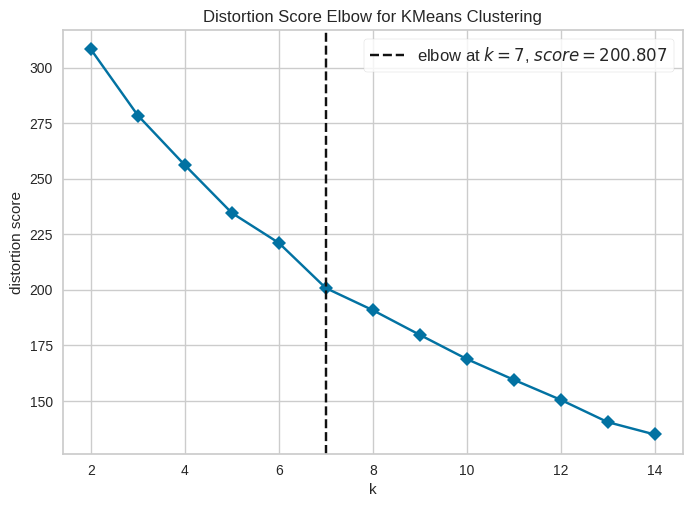

KElbowVisualizer(ax=<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=14, random_state=1), k=(2, 15),
                 timings=False)

In [30]:
from yellowbrick.cluster.elbow import kelbow_visualizer

kelbow_visualizer(KMeans(random_state=1),
                  np.asarray(X.todense()),
                  k=(2, 15),
                  timings=False)

We could also use k=4 

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_


Cluster 0
contain,clean,brass,copper,scrap,aluminum,ferrous,non,isri,per

Cluster 1
may,ferrous,electric,clean,zinc,lead,scrap,grades,cast,iron

Cluster 2
furnace,casting,non,iron,wire,percent,stainless,ferrous,scrap,steel

Cluster 3
furnace,grades,include,copper,mixed,scrap,electric,ferrous,non,weee

Cluster 4
free,wire,new,material,clean,ferrous,nonferrous,non,scrap,aluminum

Cluster 5
wire,clean,solids,copper,scrap,metals,brass,nickel,red,nonferrous

Cluster 6
new,material,zinc,mixed,lead,brass,copper,scrap,ferrous,non
None


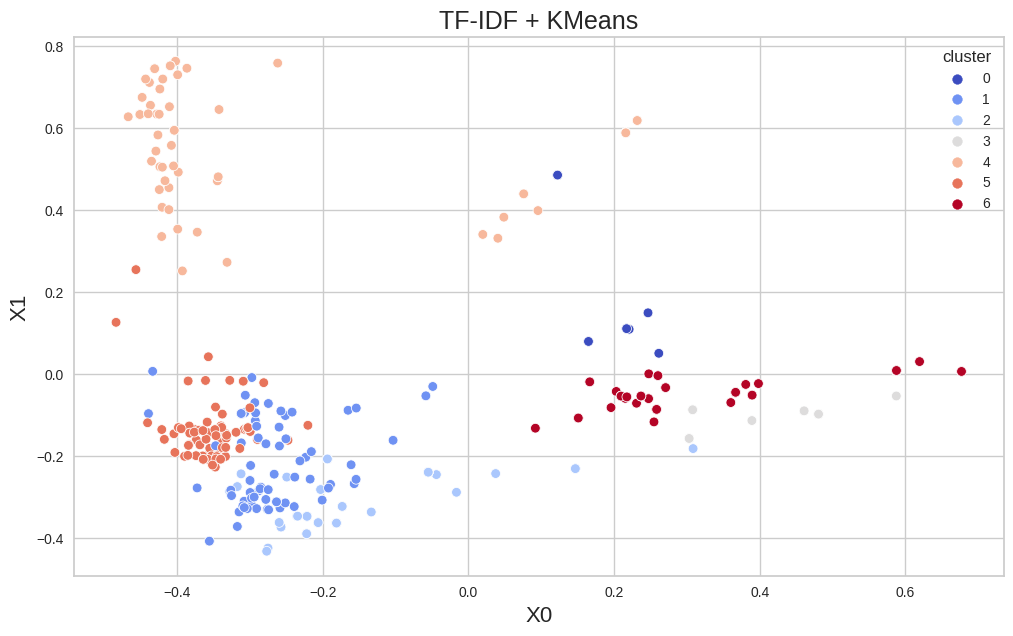

In [32]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
print(get_top_keywords(10))

plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="coolwarm")
plt.show()

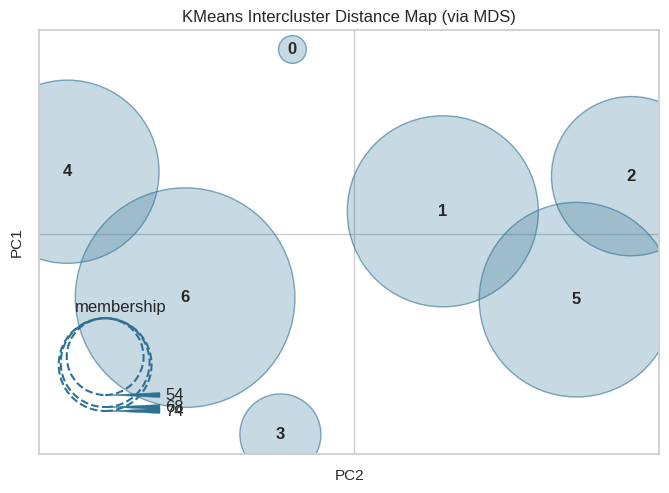

InterclusterDistance(ax=<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=7, random_state=42),
                     random_state=12)

In [33]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(kmeans, 
                      X.todense(), 
                      embedding='mds', 
                      random_state=12) # other option for embedding 'tsne'

In [34]:
df[['scrap_type', 'corpus', 'cluster']]

,scrap_type,corpus,cluster
0,sc:ISRI_0,bare uncoated unalloyed wire copper nonferrous...,5
1,sc:ISRI_1,clean untinned uncoated unalloyed wire cable c...,5
2,sc:ISRI_2,unalloyed miscellaneous wire copper nonferrous...,5
3,sc:ISRI_3,clean unalloyed uncoated clippings punchings b...,5
4,sc:ISRI_4,unalloyed miscellaneous scrap copper nonferrou...,5
...,...,...,...
316,sc:ANAMET_683,zinc scrap zamak e non ferrous,6
317,sc:ANAMET_684,lead scrap e non ferrous,6
318,sc:ANAMET_685,electric motors shredded weee non ferrous,3
319,sc:ANAMET_686,black plastic scrap weee e non ferrous,3


In [35]:
for cluster in range(len(df['cluster'].unique())): print("Cluster", cluster, ":", len(df[df['cluster'] == cluster]))

Cluster 0 : 36
Cluster 1 : 74
Cluster 2 : 54
Cluster 3 : 37
Cluster 4 : 68
Cluster 5 : 77
Cluster 6 : 103


# Cluster new _unseen_ scraps

In [36]:
X_s = df_val['corpus']

validation_vectors = vectorizer.transform(X_s)
df_val['cluster'] = kmeans.predict(validation_vectors)

print(validation_vectors.shape)

(6, 35)


/tmp/ipykernel_57776/991023937.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['cluster'] = kmeans.predict(validation_vectors)


In [37]:
df_val

,scrap_type,corpus,cluster
10,sc:ISRI_10,various types insulation sold sample recovery ...,5
100,sc:ISRI_100,clean old used foreign attachments extraneous ...,1
120,sc:ISRI_120,lead covered copper cable cable lead copper no...,1
200,sc:ISRI_200,material suitable acceptable consumer containi...,1
118,sc:ANAMET_510,brass scrap ms non ferrous,6
175,sc:ANAMET_542,scrap tlb pe without process non ferrous,6


In [38]:
from sklearn.metrics.pairwise import cosine_similarity


for idx in range(len(df_val)):


    s = df_val['corpus'].iloc[idx]
    c = df_val['cluster'].iloc[idx]

    similarity = []
    index = []
    similar_string = []
    scrap_type = []
    similarity_df = pd.DataFrame()

    df_cluster = df[df['cluster'] == c]

    for row in range(len(df_cluster)):
        s1 = df_cluster['corpus'].iloc[row]

        strings = [s, s1]
        str_sim = pd.DataFrame(data=strings)

        # vectorizer_sim = TfidfVectorizer()
        # strings_vectors = vectorizer_sim.fit_transform(str_sim[0])
        strings_vectors = vectorizer.transform(str_sim[0])

        csim = cosine_similarity(strings_vectors[0], strings_vectors[1])
        similarity.append(csim)
        index.append(row)
        similar_string.append(s1)
        scrap_type.append(df_cluster['scrap_type'].iloc[row])

    similarity_df['csim'] = similarity
    similarity_df['corpus'] = similar_string
    similarity_df['scrap_type'] = scrap_type

    similarity_df['csim'] = similarity_df['csim'].astype(float)
    similarity_df['corpus'] = similarity_df['corpus'].astype(str)
    similarity_df['scrap_type'] = similarity_df['scrap_type'].astype(str)

    print(similarity_df['csim'].idxmax(), "\n", similarity_df['csim'].max(), '\n', similarity_df['corpus'].iloc[similarity_df['csim'].idxmax()], similarity_df['scrap_type'].iloc[similarity_df['csim'].idxmax()], '\n\n', s)

5 
 0.9801614675196639 
 uncoated unalloyed chopped shredded wire scrap nodules copper nonferrous scrap red metals copper wire nodules sc:ISRI_5 

 various types insulation sold sample recovery basis subject agreement buyer seller existence jelly wire subject agreement buyer seller wire copper nonferrous scrap red metals insulated copper wire scrap
11 
 0.9427611628427388 
 metal skimmed top pot molten zinc die cast metal must unsweated unfluxed shiny smooth metallic poured molds small mounds skimmings  nonferrous scrap zinc prime zinc die cast dross sc:ISRI_110 

 clean old used foreign attachments extraneous materials deductible die castings automotive grilles zinc nonferrous scrap zinc zinc die cast automotive grilles
15 
 0.8615405840612343 
 cases either plastic rubber complete including caps non lead nicad ni fe carbonaire etc acceptable whole intact lead lead nonferrous scrap lead scrap drained dry whole intact lead sc:ISRI_118 

 lead covered copper cable cable lead copper nonf

In [39]:
pca_s_vecs = pca.transform(validation_vectors.toarray())

x0 = pca_s_vecs[:, 0]
x1 = pca_s_vecs[:, 1]

df_val['x0'] = x0
df_val['x1'] = x1

/tmp/ipykernel_57776/1149053935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['x0'] = x0
/tmp/ipykernel_57776/1149053935.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['x1'] = x1


In [40]:
s = ['Open Extinguisher with no heads | 6061 grade',
     'Regulary purchase of galvalume dross, capacity 300-500mt/month',
     'With no cable, plate or grit. CuSN in cable, plate or grit, separately. Not mixed. In the case of small packaged (30x30 cm) and palletized cable, ball and shot in BIG BAGS',
     'Clean copper aluminum radiator without iron, the price may vary depending on the LME of the copper Lowest 3 months 7656€.']

df_s = pd.DataFrame()
df_s['corpus'] = s
df_s['corpus'] = hero.clean(df_s['corpus'])

X_s = df_s['corpus']

validation_vectors = vectorizer.transform(X_s)
df_s['cluster'] = kmeans.predict(validation_vectors)

print(validation_vectors.shape)

(4, 35)


In [41]:
pca_s_vecs = pca.transform(validation_vectors.toarray())

x0 = pca_s_vecs[:, 0]
x1 = pca_s_vecs[:, 1]

df_s['x0'] = x0
df_s['x1'] = x1

In [42]:
df_s

,corpus,cluster,x0,x1
0,open extinguisher heads grade,1,-0.167801,-0.078897
1,regulary purchase galvalume dross capacity 500...,1,-0.167801,-0.078897
2,cable plate grit cusn cable plate grit separat...,1,-0.184054,-0.078671
3,clean copper aluminum radiator without iron pr...,1,-0.334286,0.104089


In [43]:
df_val = df_s.copy()

for idx in range(len(df_val)):

    s = df_val['corpus'].iloc[idx]
    c = df_val['cluster'].iloc[idx]

    similarity = []
    index = []
    similar_string = []
    scrap_type = []
    similarity_df = pd.DataFrame()

    df_cluster = df[df['cluster'] == c]

    for row in range(len(df_cluster)):
        s1 = df_cluster['corpus'].iloc[row]

        strings = [s, s1]
        str_sim = pd.DataFrame(data=strings)

        # vectorizer_sim = TfidfVectorizer()
        # strings_vectors = vectorizer_sim.fit_transform(str_sim[0])
        strings_vectors = vectorizer.transform(str_sim[0])

        csim = cosine_similarity(strings_vectors[0], strings_vectors[1])
        similarity.append(csim)
        index.append(row)
        similar_string.append(s1)
        scrap_type.append(df_cluster['scrap_type'].iloc[row])

    similarity_df['csim'] = similarity
    similarity_df['corpus'] = similar_string
    similarity_df['scrap_type'] = scrap_type

    similarity_df['csim'] = similarity_df['csim'].astype(float)
    similarity_df['corpus'] = similarity_df['corpus'].astype(str)
    similarity_df['scrap_type'] = similarity_df['scrap_type'].astype(str)

    print(similarity_df['csim'].idxmax(), "\n", similarity_df['csim'].max(), '\n', similarity_df['corpus'].iloc[similarity_df['csim'].idxmax()], similarity_df['scrap_type'].iloc[similarity_df['csim'].idxmax()], '\n\n', s)

0 
 0.0 
 miscellaneous old zinc base die castings without iron foreign attachments unmeltables dirt foreign attachments volatile substances rubber cork plastic grease etc deductible material containing excess iron constitute good delivery die castings zinc nonferrous scrap zinc old zinc die cast scrap sc:ISRI_98 

 open extinguisher heads grade
0 
 0.0 
 miscellaneous old zinc base die castings without iron foreign attachments unmeltables dirt foreign attachments volatile substances rubber cork plastic grease etc deductible material containing excess iron constitute good delivery die castings zinc nonferrous scrap zinc old zinc die cast scrap sc:ISRI_98 

 regulary purchase galvalume dross capacity 500mt month
27 
 0.6391561312808985 
 shall consist lead base bearing metal containing less tin  babbit nonferrous scrap mixed common babbitt sc:ISRI_157 

 cable plate grit cusn cable plate grit separately mixed case small packaged 30x30 cm palletized cable ball shot big bags
33 
 0.473630

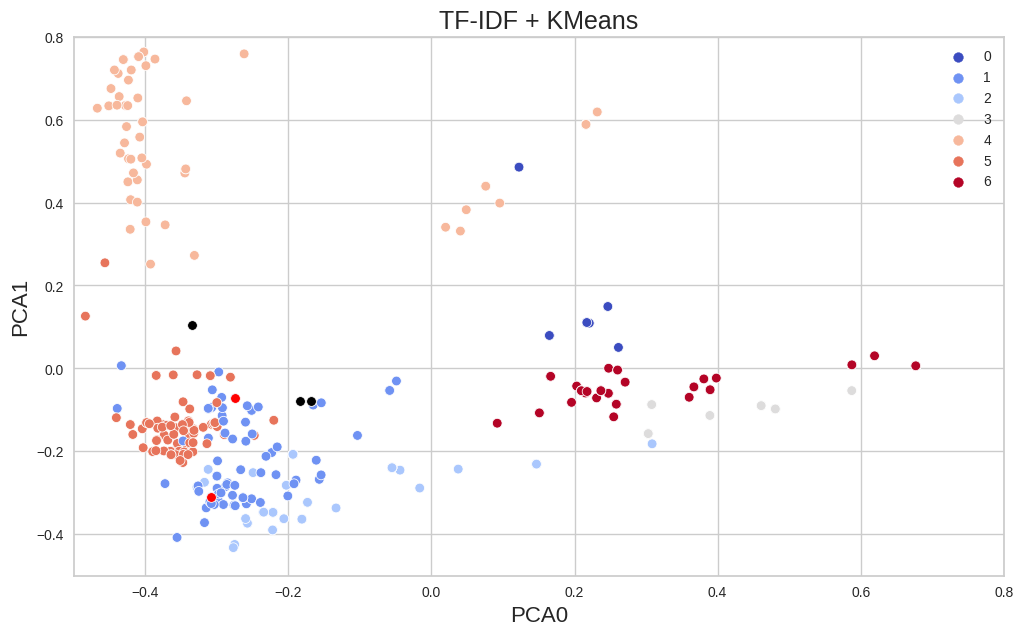

In [52]:
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("PCA0", fontdict={"fontsize": 16})
plt.ylabel("PCA1", fontdict={"fontsize": 16})
plt.xlim(-0.5, 0.8)
plt.ylim(-0.5, 0.8)
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="coolwarm")
sns.scatterplot(data=df[df['scrap_type'] == 'sc:ISRI_157'], x='x0', y='x1', color='red')
sns.scatterplot(data=df[df['scrap_type'] == 'sc:ISRI_179'], x='x0', y='x1', color='red')

sns.scatterplot(data=df_s, x='x0', y='x1', color='black')
plt.show()

In [54]:
df[df['scrap_type'] == 'sc:ISRI_179']

,scrap_type,corpus,cluster,x0,x1
179,sc:ISRI_179,clean may include badly rusted corroded stock ...,1,-0.308002,-0.310283


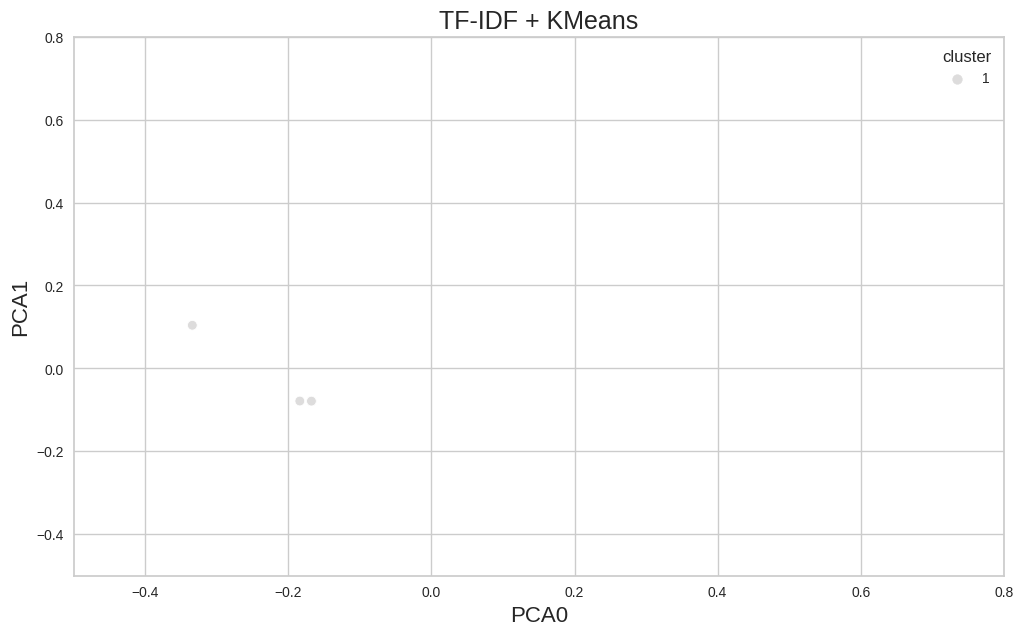

In [46]:
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("PCA0", fontdict={"fontsize": 16})
plt.ylabel("PCA1", fontdict={"fontsize": 16})
plt.xlim(-0.5, 0.8)
plt.ylim(-0.5, 0.8)
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df_s, x='x0', y='x1', hue='cluster', palette="coolwarm")
plt.show()